# Import thư viện

In [ ]:
import codecs
import csv
import re
import sys

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

# Đọc dữ liệu


In [ ]:
path = "/content/drive/MyDrive/Tự học/NLP/NLP-CNWEB/train_tieng_viet.txt"

In [ ]:
# Đọc dữ liệu
with open(path, 'r', encoding='utf-8') as f:
  train_output = f.readlines()

print('Number of sequences: ', len(train_output))
print('First sequence: ', train_output[0])

Number of sequences:  3624432
First sequence:  0000000000	Trang Chính



# Hàm xóa dấu

In [ ]:
def remove_tone_line(utf8_str):
    intab_l = "ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđ"
    intab_u = "ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ"
    intab = list(intab_l+intab_u)

    outtab_l = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"
    outtab_u = "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"
    outtab = outtab_l + outtab_u
    # Khởi tạo regex tìm kiếm các vị trí nguyên âm có dấu 'ạ|ả|ã|...'
    r = re.compile("|".join(intab))

    # Dictionary có key-value là từ có dấu-từ không dấu. VD: {'â' : 'a'}
    replaces_dict = dict(zip(intab, outtab))
    # Thay thế các từ có dấu xuất hiện trong tìm kiếm của regex bằng từ không dấu tương ứng
    non_dia_str = r.sub(lambda m: replaces_dict[m.group(0)], utf8_str)
    return non_dia_str

In [ ]:
from tqdm import tqdm
train_idx_500k = [] #index của dữ liệu
train_opt_500k = [] # dữ liệu chưa xóa dấu
train_ipt_500k = [] # dữ liệu đã xóa dấu
val_idx_50k = []
val_opt_50k = []
val_ipt_50k = []
test_idx_50k = []
test_opt_50k = []
test_ipt_50k = []

for i in tqdm(range(600000)):
  [idx, origin_seq] = train_output[i].split('\t')
  try:
    non_acc_seq = remove_tone_line(origin_seq)
  except:
    print('error remove tone line at sequence {}', str(i))
    next
  if i < 500000:
    train_idx_500k.append(idx)
    train_opt_500k.append(origin_seq)
    train_ipt_500k.append(non_acc_seq)
  elif i < 550000:
    val_idx_50k.append(idx)
    val_opt_50k.append(origin_seq)
    val_ipt_50k.append(non_acc_seq)
  else:
    test_idx_50k.append(idx)
    test_opt_50k.append(origin_seq)
    test_ipt_50k.append(non_acc_seq)

100%|██████████| 600000/600000 [00:36<00:00, 16341.95it/s]


In [ ]:
import pickle

def _save_pickle(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)

_save_pickle('train_tv_idx_500k.pkl', train_idx_500k)
_save_pickle('val_tv_idx_50k.pkl', val_idx_50k)
_save_pickle('test_tv_idx_50k.pkl', test_idx_50k)


# Xây dựng mô hình Transformer

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
# train_examples = tf.data.Dataset.from_tensor_slices((train_ipt_100k, train_opt_100k))
train_examples = tf.data.Dataset.from_tensor_slices((train_ipt_500k, train_opt_500k))
val_examples = tf.data.Dataset.from_tensor_slices((val_ipt_50k, val_opt_50k))

In [ ]:
# Khởi tạo tokenize cho tập train input và output
train_text = [ipt.numpy() for (ipt, opt) in train_examples]
target_vocab_size = 2**13

# Build tokenizer for input
tokenizer_ipt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train_text, target_vocab_size=target_vocab_size)

# Build tokenizer for output
tokenizer_opt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train_text, target_vocab_size=target_vocab_size)


In [ ]:
sample_string = 'Tiếng Việt là ngôn ngữ trong sáng nhất thế giới'

tokenized_string = tokenizer_opt.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_opt.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [1533, 8164, 8125, 8130, 1191, 2063, 8164, 8126, 8074, 381, 8047, 8134, 8099, 7971, 964, 8134, 8119, 380, 964, 8164, 8126, 8114, 7971, 11, 8054, 8134, 8100, 1191, 5110, 8164, 8125, 8104, 381, 2458, 8164, 8125, 8130, 7971, 1342, 8164, 8126, 8094, 8044]
The original string: Tiếng Việt là ngôn ngữ trong sáng nhất thế giới


In [ ]:
def _save_pickle(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle('tokenizer_ipt.pkl', tokenizer_ipt)
_save_pickle('tokenizer_opt.pkl', tokenizer_opt)


In [ ]:
def encode(ipt, opt):
  ipt = [tokenizer_ipt.vocab_size] + tokenizer_ipt.encode(
      ipt.numpy()) + [tokenizer_ipt.vocab_size+1]

  opt = [tokenizer_opt.vocab_size] + tokenizer_opt.encode(
      opt.numpy()) + [tokenizer_opt.vocab_size+1]

  return ipt, opt

In [ ]:
def tf_encode(ipt, opt):
  result_ipt, result_opt = tf.py_function(encode, [ipt, opt], [tf.int64, tf.int64])
  result_ipt.set_shape([None])
  result_opt.set_shape([None])
  return result_ipt, result_opt

In [ ]:
next(iter(train_examples))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Trang Chinh\n'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Trang Ch\xc3\xadnh\n'>)

In [ ]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
print('tokenizer_ipt.vocab_size: ', tokenizer_ipt.vocab_size)
x, y = next(iter(train_dataset))
print('input shape: ', x.shape)
print('output shape: ', y.shape)
print('first row of input index: ', x[0, :])

tokenizer_ipt.vocab_size:  8195
input shape:  (64, 32)
output shape:  (64, 39)
first row of input index:  tf.Tensor(
[8195  363 1068 7949 8196    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int64)


# Position Encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model) # shape (position, d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32) # shape: (position, d_model)

(1, 50, 512)


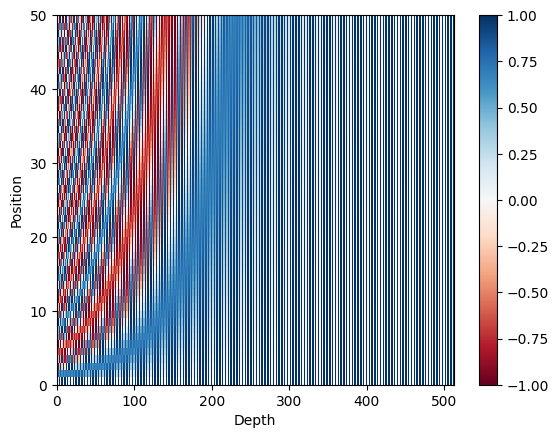

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scale dot Product attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32) # depth
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
# with tf.Session() as sess:
mask = tf.constant([[0, 1, 1],
                    [0, 0, 1],
                    [0, 0, 0]], dtype = tf.float64)

scaled_attention_logit = tf.constant([[1, 3, 10],
                [1, 2, 5],
                [1, 1, 5]], dtype = tf.float64)

scaled_attention_logit += (mask * -1e9)
attention_weights = tf.nn.softmax(scaled_attention_logit, axis=-1)
print('scaled_attention_logit: ', scaled_attention_logit)
print('attention_weights: ', attention_weights)

scaled_attention_logit:  tf.Tensor(
[[ 1.00000000e+00 -9.99999997e+08 -9.99999990e+08]
 [ 1.00000000e+00  2.00000000e+00 -9.99999995e+08]
 [ 1.00000000e+00  1.00000000e+00  5.00000000e+00]], shape=(3, 3), dtype=float64)
attention_weights:  tf.Tensor(
[[1.         0.         0.        ]
 [0.26894142 0.73105858 0.        ]
 [0.01766842 0.01766842 0.96466316]], shape=(3, 3), dtype=float64)


In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


# Multi-head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point wise feed forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder and Decoder

### Encoder layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

### Decoder layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

# Init sample tensorflow with shape 64 x 62 and data type int.
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

In [1]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

NameError: name 'tf' is not defined

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Create transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):
    # print('enc_padding_mask: ', enc_padding_mask)
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Set hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_ipt.vocab_size + 2
target_vocab_size = tokenizer_opt.vocab_size + 2
dropout_rate = 0.1

In [ ]:
print('input_vocab_size: ',  input_vocab_size)
print('target_vocab_size: ', target_vocab_size)

input_vocab_size:  8197
target_vocab_size:  8197


# Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is cast to float
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

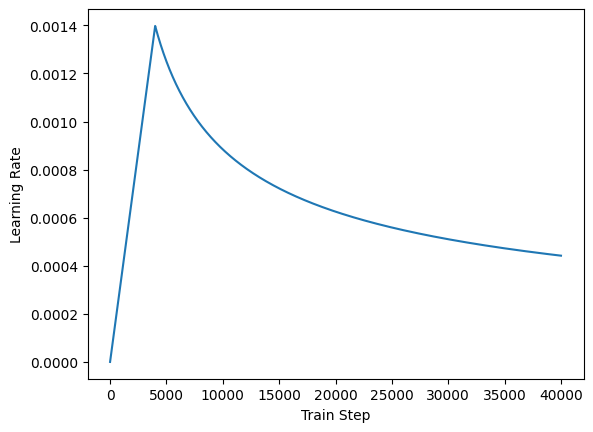

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and Metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Training and checkpointing

In [ ]:
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                          input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
x = tf.constant([[7, 6, 0, 0, 0], [1, 2, 3, 0, 0], [6, 0, 0, 0, 0]])
y = tf.constant([[1, 4, 5, 0, 0], [1, 4, 3, 0, 0], [1, 2, 0, 0, 0]])
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(x, y)


In [ ]:
combined_mask


<tf.Tensor: shape=(3, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.]]]], dtype=float32)>

In [ ]:
checkpoint_path = "./checkpoints/train_500k"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)

    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> non_diacritic, tar -> diacritic
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0435 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9579 Accuracy 0.0019
Epoch 1 Batch 100 Loss 8.8027 Accuracy 0.0175
Epoch 1 Batch 150 Loss 8.6378 Accuracy 0.0227
Epoch 1 Batch 200 Loss 8.4341 Accuracy 0.0236
Epoch 1 Batch 250 Loss 8.1845 Accuracy 0.0241
Epoch 1 Batch 300 Loss 7.9030 Accuracy 0.0269
Epoch 1 Batch 350 Loss 7.6097 Accuracy 0.0332
Epoch 1 Batch 400 Loss 7.3330 Accuracy 0.0390
Epoch 1 Batch 450 Loss 7.0834 Accuracy 0.0447
Epoch 1 Batch 500 Loss 6.8506 Accuracy 0.0509
Epoch 1 Batch 550 Loss 6.6181 Accuracy 0.0575
Epoch 1 Batch 600 Loss 6.3946 Accuracy 0.0635
Epoch 1 Batch 650 Loss 6.1872 Accuracy 0.0686
Epoch 1 Batch 700 Loss 6.0044 Accuracy 0.0727
Epoch 1 Batch 750 Loss 5.8368 Accuracy 0.0761
Epoch 1 Batch 800 Loss 5.6834 Accuracy 0.0795
Epoch 1 Batch 850 Loss 5.5450 Accuracy 0.0830
Epoch 1 Batch 900 Loss 5.4196 Accuracy 0.0863
Epoch 1 Batch 950 Loss 5.3072 Accuracy 0.0891
Epoch 1 Batch 1000 Loss 5.2111 Accuracy 0.0914
Epoch 1 Batch 1050 Loss 5.1266 Accur

# Evaluate

In [ ]:
vr = 50

def evaluate(inp_sentence):
  start_token = [tokenizer_ipt.vocab_size]
  end_token = [tokenizer_ipt.vocab_size + 1]

  # inp sentence is non_diacritic, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ipt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # as the target is exist diacritic, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_opt.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_opt.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_ipt.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[tokenizer_ipt.decode([i]) for i in sentence]+['<end>'],
        fontdict=fontdict, rotation=90)

    ax.set_yticklabels([tokenizer_opt.decode([i]) for i in result
                        if i < tokenizer_opt.vocab_size],
                       fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_opt.decode([i for i in result
                                            if i < tokenizer_opt.vocab_size])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
translate("tieng Viet la ngon ngu trong sang nhat the gioi")


Input: tieng Viet la ngon ngu trong sang nhat the gioi
Predicted translation: tiếng Việt là ngôn ngữ trong sang nhất thế giới



In [ ]:
translate("Anh that su yeu em rat nhieu")

Input: Anh that su yeu em rat nhieu
Predicted translation: Anh thất sư yêu em rất nhiều



In [ ]:
translate("Ao ma ca na da that su luon!")

Input: Ao ma ca na da that su luon!
Predicted translation: Áo ma cá ná đã thật sự lươn!



In [ ]:
translate("Cuoc song la nhung thang tram")

Input: Cuoc song la nhung thang tram
Predicted translation: Cuộc sông là những �ng trăm



In [ ]:
translate("Hom nay troi that la dep Toi di bo quanh mot canh dong.")